<a href="https://colab.research.google.com/github/FVargasData/wpgPermits/blob/Final/Datathon2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [77]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import logging

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score

# Set seaborn pastel palette for visualizations

In [78]:
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Set logging configuration

In [79]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration and API parameters

In [80]:
API_URL = "https://data.winnipeg.ca/resource/urbd-qygv.json"
APP_TOKEN = "CvU5WTCBwn36S6Vxebw1QjJVd"
CHUNK_SIZE = 1000  # number of rows per request (Socrata default)
MAX_ROWS = 330000  # maximum rows expected

# Columns to be retained based on our analysis

In [81]:
COLUMNS_TO_KEEP = [
    "issue_date", "permit_group", "permit_type", "sub_type", "work_type",
    "neighbourhood_name", "community", "ward", "application_received_date", "status",
    "x_coordinate_nad83", "y_coordinate_nad83"
]

#FUNCTIONS SECTION

## This function will Fetch all rows from the API using pagination. I will return a DataFrame containing all the data.

In [82]:
def fetch_data(api_url, app_token, chunk_size=1000, max_rows=330000):
    headers = {"X-App-Token": app_token}
    all_data = []
    offset = 0

    logging.info("Starting data collection from API...")
    while offset < max_rows:
        params = {
            "$limit": chunk_size,
            "$offset": offset
        }
        try:
            response = requests.get(api_url, headers=headers, params=params)
            response.raise_for_status()
            data_chunk = response.json()
            if not data_chunk:
                logging.info("No more data returned from API.")
                break
            all_data.extend(data_chunk)
            offset += chunk_size
            logging.info(f"Fetched {len(data_chunk)} rows; total so far: {len(all_data)}")
            # To avoid hitting rate limits
            time.sleep(0.2)
        except Exception as e:
            logging.error("Error during API request: " + str(e))
            break

    logging.info(f"Data collection complete. Total rows fetched: {len(all_data)}")
    return pd.DataFrame(all_data)

## Clean and preprocess the raw DataFrame.

In [83]:
def clean_data(df):

    # Retain only the required columns (if present)
    df = df[[col for col in COLUMNS_TO_KEEP if col in df.columns]].copy()

    # Convert date columns to datetime
    for col in ['issue_date', 'application_received_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            assert df[col].dtype == '<M8[ns]', f"Column {col} was not converted properly."

    # Convert coordinate columns to numeric
    for col in ['x_coordinate_nad83', 'y_coordinate_nad83']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Optional: Clean text columns (strip whitespace)
    text_cols = ['permit_group', 'permit_type', 'sub_type', 'work_type',
                 'neighbourhood_name', 'community', 'ward', 'status']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    logging.info("Data cleaning complete.")
    return df

## Process data by adding derived fields.

In [84]:
def process_data(df):

    # Extract year and quarter for grouping
    if "issue_date" in df.columns:
        df["year"] = df["issue_date"].dt.year
        df["quarter"] = df["issue_date"].dt.quarter

        # Create a combined quarter-year field for ease of plotting (e.g., "2022-Q1")
        df["quarter_year"] = df["year"].astype(str) + "-Q" + df["quarter"].astype(str)
        logging.info("Quarter and year columns created.")
    else:
        logging.warning("issue_date column missing, cannot process quarterly fields.")
    return df

## Perform exploratory data analysis (EDA)

In [85]:
def explore_data(df):

    # Permits per quarter per year
    plt.figure(figsize=(15, 6))  # Increased width for better spacing
    quarter_counts = df["quarter_year"].value_counts().sort_index()
    sns.barplot(x=quarter_counts.index, y=quarter_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel("Quarter-Year")
    plt.ylabel("Number of Permits")
    plt.title("Number of Permits per Quarter-Year")
    plt.tight_layout()
    plt.show()

    # Space between charts
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Distribution of Permit Type
    plt.figure(figsize=(15, 6)) # Increased width for better spacing
    sns.countplot(data=df, x="permit_type", order=df["permit_type"].value_counts().index)
    plt.xticks(rotation=45)
    plt.title("Distribution of Permit Types")
    plt.tight_layout()
    plt.show()

    # Space between charts.
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Trend of permits per neighbourhood
    plt.figure(figsize=(15, 6)) # Increased width for better spacing
    neighbourhood_counts = df["neighbourhood_name"].value_counts().head(10)
    sns.barplot(x=neighbourhood_counts.index, y=neighbourhood_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel("Neighbourhood Name (Top 10)")
    plt.ylabel("Number of Permits")
    plt.title("Top 10 Neighbourhoods by Permit Count")
    plt.tight_layout()
    plt.show()

    # Space between charts.
    plt.figure(figsize=(0.1, 0.1)) #create a blank plot for spacing.
    plt.show()

    # Map chart: scatter plot of coordinates colored by permits
    if "x_coordinate_nad83" in df.columns and "y_coordinate_nad83" in df.columns:
        plt.figure(figsize=(15, 8)) # Increased width and height for better spacing
        sns.scatterplot(data=df, x="x_coordinate_nad83", y="y_coordinate_nad83", hue="permit_type") #added legend
        plt.xlabel("X Coordinate (NAD83)")
        plt.ylabel("Y Coordinate (NAD83)")
        plt.title("Map Chart: Winnipeg Permit Locations")
        plt.tight_layout()
        plt.show()

    logging.info("Exploratory data analysis complete.")

## Prepare features for prediction tasks.

In [86]:
def prepare_features_for_prediction(df, group_by_field):

    # Ensure necessary columns exist
    required = ['quarter', group_by_field, 'permit_type']
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Create a new DataFrame for modeling
    model_df = df.copy()
    # We'll use 'quarter' (as categorical) and the grouping field as features
    features = model_df[[ 'quarter', group_by_field ]].copy() #make copy to avoid warnings.

    # Encode categorical variables
    le_quarter = LabelEncoder()
    features.loc[:, "quarter_encoded"] = le_quarter.fit_transform(features["quarter"])

    le_group = LabelEncoder()
    features.loc[:, f"{group_by_field}_encoded"] = le_group.fit_transform(features[group_by_field])

    # Combine encoded features
    X = features[[ "quarter_encoded", f"{group_by_field}_encoded" ]]

    # Encode target
    le_target = LabelEncoder()
    y = le_target.fit_transform(model_df["permit_type"])

    return X, y, le_quarter, le_group, le_target

## Build a predictive model based on model_type, split the data, train the model, and evaluate its performance. Returns the trained model and its performance metrics.

In [87]:
def build_and_evaluate_model(X, y, model_type="DecisionTree"):

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize model
    if model_type == "DecisionTree":
        model = DecisionTreeClassifier(random_state=42)
    elif model_type == "RandomForest":
        model = RandomForestClassifier(random_state=42, n_estimators=100)
    else:
        raise ValueError("Invalid model type specified. Use 'DecisionTree' or 'RandomForest'.")

    # Train model with error handling
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        logging.error(f"Error training model: {e}")
        raise e

    # Evaluate model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    logging.info(f"{model_type} Accuracy: {accuracy:.3f}")
    return model, accuracy, report

## Run predictive modeling for both analysis points

In [106]:
def run_predictive_analysis(df):
    results = {}
    for group_field in ['neighbourhood_name', 'ward']:
        X, y, le_quarter, le_group, le_target = prepare_features_for_prediction(df, group_field)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Decision Tree
        dt = DecisionTreeClassifier(random_state=42)
        dt.fit(X_train, y_train)
        dt_pred = dt.predict(X_test)
        dt_accuracy = accuracy_score(y_test, dt_pred)
        dt_f1 = f1_score(y_test, dt_pred, average='weighted', zero_division=0)
        dt_cm = confusion_matrix(y_test, dt_pred)
        dt_recall = recall_score(y_test, dt_pred, average='weighted', zero_division=0)

        # Random Forest (with class weights)
        rf = RandomForestClassifier(random_state=42, class_weight='balanced')
        rf.fit(X_train, y_train)
        rf_pred = rf.predict(X_test)
        rf_accuracy = accuracy_score(y_test, rf_pred)
        rf_f1 = f1_score(y_test, rf_pred, average='weighted', zero_division=0)
        rf_cm = confusion_matrix(y_test, rf_pred)
        rf_recall = recall_score(y_test, rf_pred, average='weighted', zero_division=0)

        # Determine best model based on a combined evaluation
        if (dt_f1 > rf_f1 and dt_accuracy >= rf_accuracy and dt_recall >= rf_recall) or (dt_f1 >= rf_f1 and dt_accuracy > rf_accuracy and dt_recall >= rf_recall) or (dt_f1 >= rf_f1 and dt_accuracy >= rf_accuracy and dt_recall > rf_recall):
            best_model = 'DecisionTree'
            model = dt
        else:
            best_model = 'RandomForest'
            model = rf

        results[group_field] = {
            'DecisionTree': {'accuracy': dt_accuracy, 'f1': dt_f1, 'recall': dt_recall, 'report': classification_report(y_test, dt_pred, zero_division=0), 'confusion_matrix': dt_cm, 'le_quarter': le_quarter, 'le_group': le_group, 'le_target': le_target},
            'RandomForest': {'accuracy': rf_accuracy, 'f1': rf_f1, 'recall': rf_recall, 'report': classification_report(y_test, rf_pred, zero_division=0), 'confusion_matrix': rf_cm, 'le_quarter': le_quarter, 'le_group': le_group, 'le_target': le_target},
            'BestModel': best_model,
            'model': model,
            'le_quarter': le_quarter,
            'le_group': le_group,
            'le_target': le_target
        }
    return results

## Predict permit types for the current year based on historical data.

In [107]:
def predict_current_year(df, current_year, predictive_results, group_field):
    current_year_quarters = [f"{current_year}-Q{q}" for q in range(1, 5)]
    current_year_df = pd.DataFrame({
        'quarter_year': current_year_quarters,
        group_field: df[group_field].unique()[0]
    })

    best_model_name = predictive_results[group_field]['BestModel']
    model_data = predictive_results[group_field][best_model_name]

    le_quarter = model_data['le_quarter']
    le_group = model_data['le_group']
    le_target = model_data['le_target']

    current_year_df['quarter'] = current_year_df['quarter_year'].str.split('-Q').str[1].astype(int)
    current_year_df['quarter_encoded'] = le_quarter.transform(current_year_df['quarter'])
    current_year_df[f"{group_field}_encoded"] = le_group.transform([current_year_df[group_field].unique()[0]])[0]

    X_predict = current_year_df[['quarter_encoded', f"{group_field}_encoded"]]
    predictions = predictive_results[group_field]['model'].predict(X_predict)
    predicted_permit_types = le_target.inverse_transform(predictions)

    current_year_df['predicted_permit_type'] = predicted_permit_types
    return current_year_df

## Visualize funcitonality

### 1. Data Collection

In [90]:
df_raw = fetch_data(API_URL, APP_TOKEN, chunk_size=CHUNK_SIZE, max_rows=100000)

if df_raw.empty:
  logging.error("No data fetched. Exiting.")

print(df_raw.head())

                issue_date permit_number permit_group             permit_type  \
0  2021-03-24T00:00:00.000  21-130863 ER        Trade  Electrical Residential   
1  2021-06-16T00:00:00.000  21-164934 ER        Trade  Electrical Residential   
2  2021-06-16T00:00:00.000  21-168248 PR        Trade    Plumbing Residential   
3  2021-11-04T00:00:00.000  21-233173 PR        Trade    Plumbing Residential   
4  2021-04-06T00:00:00.000  21-134716 EC        Trade   Electrical Commercial   

                         sub_type               work_type street_number  \
0                       Homeowner            Service Only            15   
1                       Homeowner            Service Only            94   
2                       Homeowner       Plumb Lower Level            34   
3    Licensed Plumbing Contractor           Plumb New SFD          1831   
4  Licensed Electrical Contractor  Temporary Installation           606   

  street_name street_type neighbourhood_number  ...  \
0     D

### 2. Data Cleaning

In [91]:
df_clean = clean_data(df_raw)

print(df_clean.head())

  issue_date permit_group             permit_type  \
0 2021-03-24        Trade  Electrical Residential   
1 2021-06-16        Trade  Electrical Residential   
2 2021-06-16        Trade    Plumbing Residential   
3 2021-11-04        Trade    Plumbing Residential   
4 2021-04-06        Trade   Electrical Commercial   

                         sub_type               work_type neighbourhood_name  \
0                       Homeowner            Service Only          SOUTHDALE   
1                       Homeowner            Service Only       ISLAND LAKES   
2                       Homeowner       Plumb Lower Level          MEADOWOOD   
3    Licensed Plumbing Contractor           Plumb New SFD         BROOKLANDS   
4  Licensed Electrical Contractor  Temporary Installation           McMILLAN   

                    community          ward application_received_date  status  \
0                        Riel  St. Boniface                2021-03-24  Issued   
1                        Riel  St. Bon

### 3. Data Processing

In [92]:
df_processed = process_data(df_clean)

print(df_processed.head())

  issue_date permit_group             permit_type  \
0 2021-03-24        Trade  Electrical Residential   
1 2021-06-16        Trade  Electrical Residential   
2 2021-06-16        Trade    Plumbing Residential   
3 2021-11-04        Trade    Plumbing Residential   
4 2021-04-06        Trade   Electrical Commercial   

                         sub_type               work_type neighbourhood_name  \
0                       Homeowner            Service Only          SOUTHDALE   
1                       Homeowner            Service Only       ISLAND LAKES   
2                       Homeowner       Plumb Lower Level          MEADOWOOD   
3    Licensed Plumbing Contractor           Plumb New SFD         BROOKLANDS   
4  Licensed Electrical Contractor  Temporary Installation           McMILLAN   

                    community          ward application_received_date  status  \
0                        Riel  St. Boniface                2021-03-24  Issued   
1                        Riel  St. Bon

### 4. Exploratory Data Analysis (visualizations)

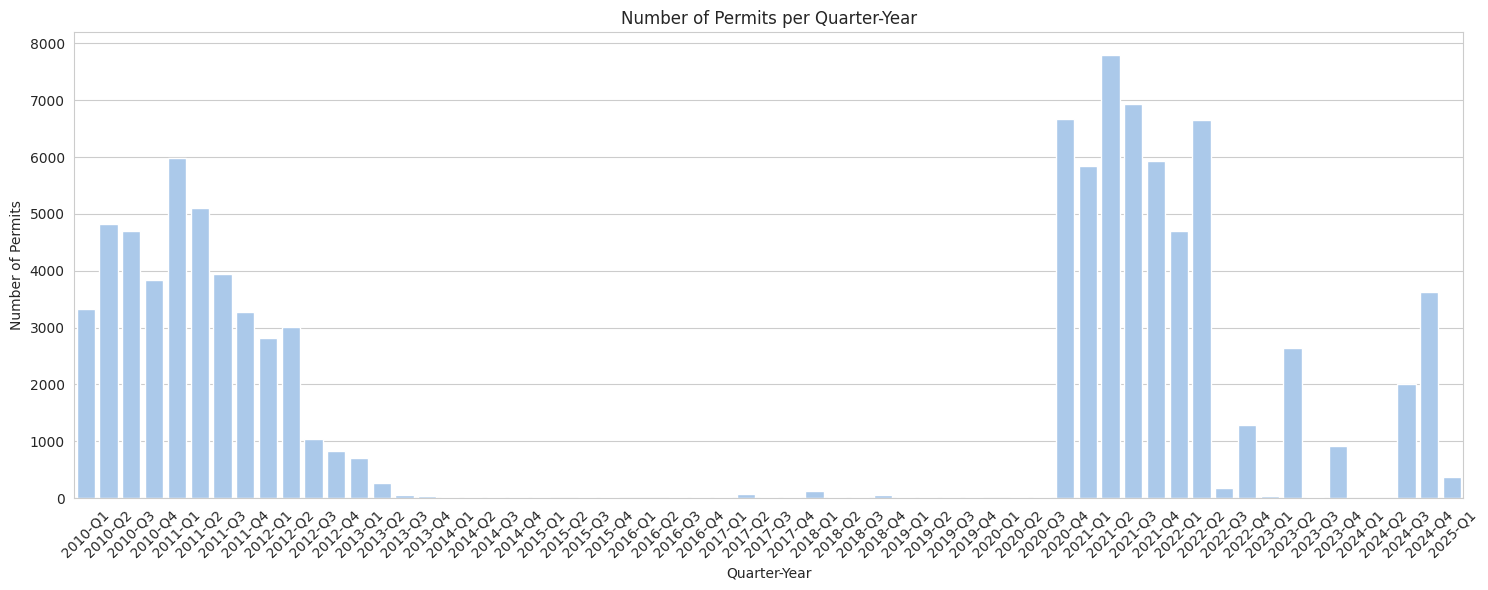

<Figure size 10x10 with 0 Axes>

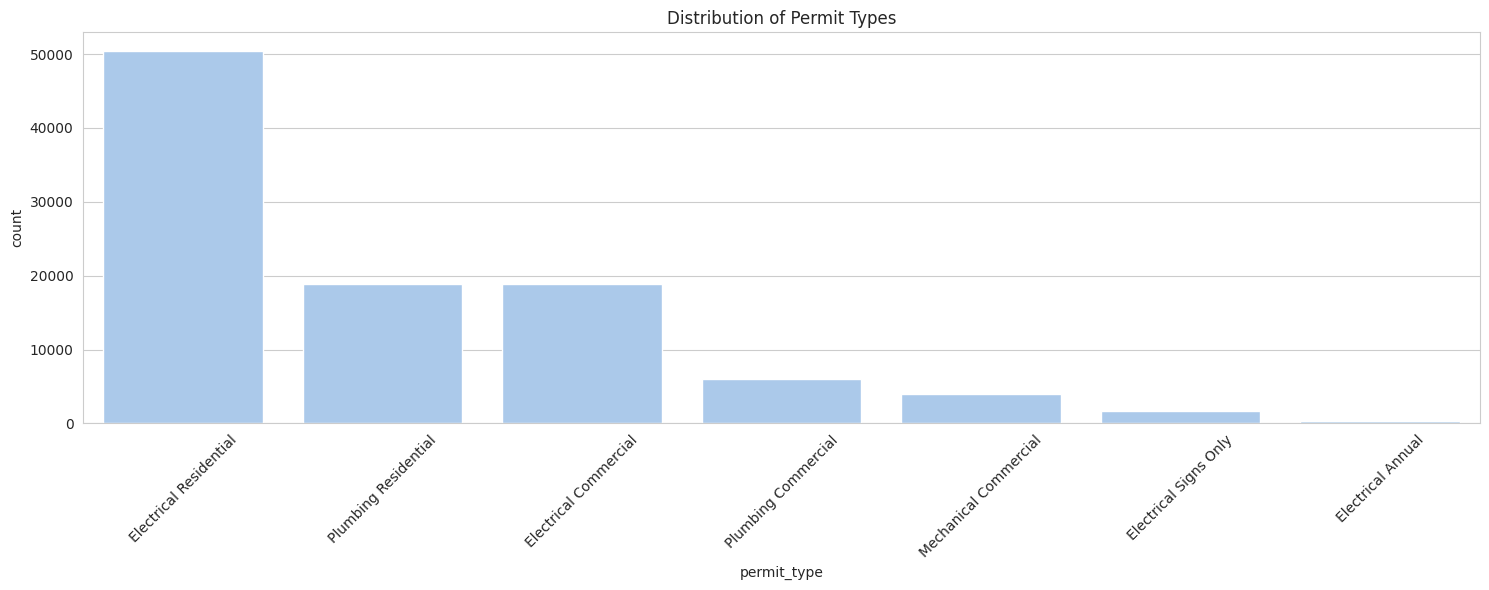

<Figure size 10x10 with 0 Axes>

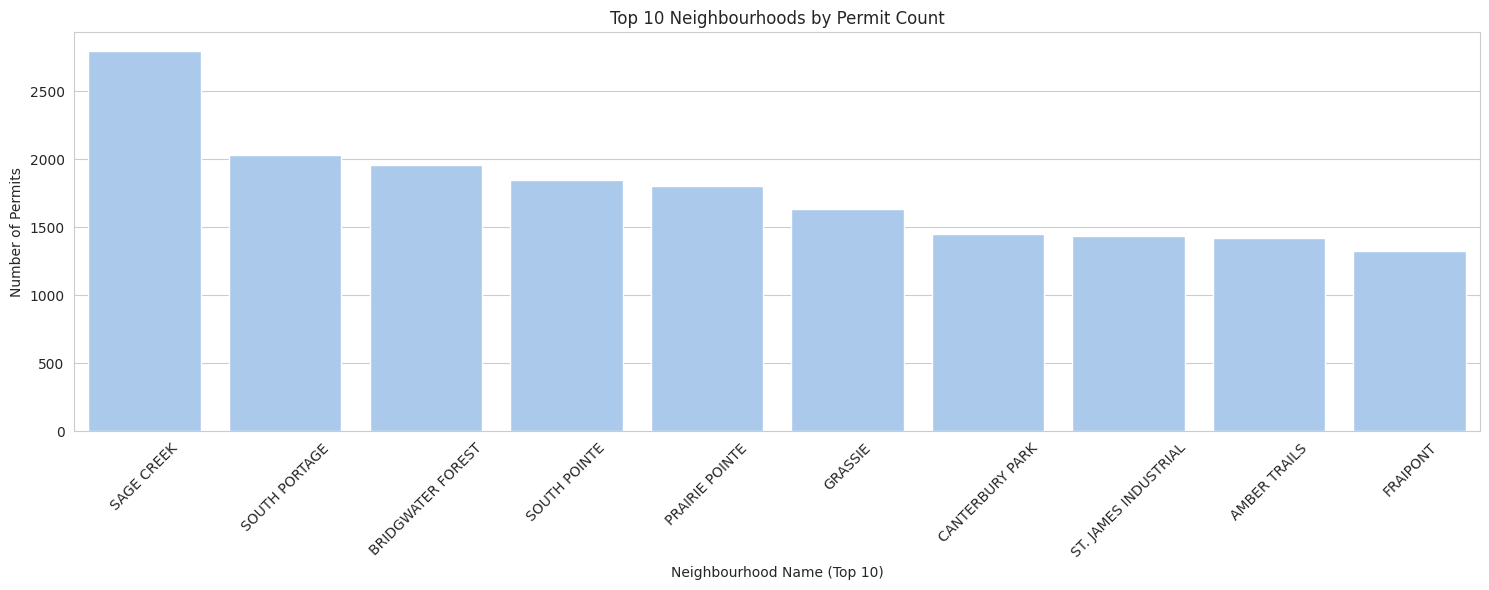

<Figure size 10x10 with 0 Axes>

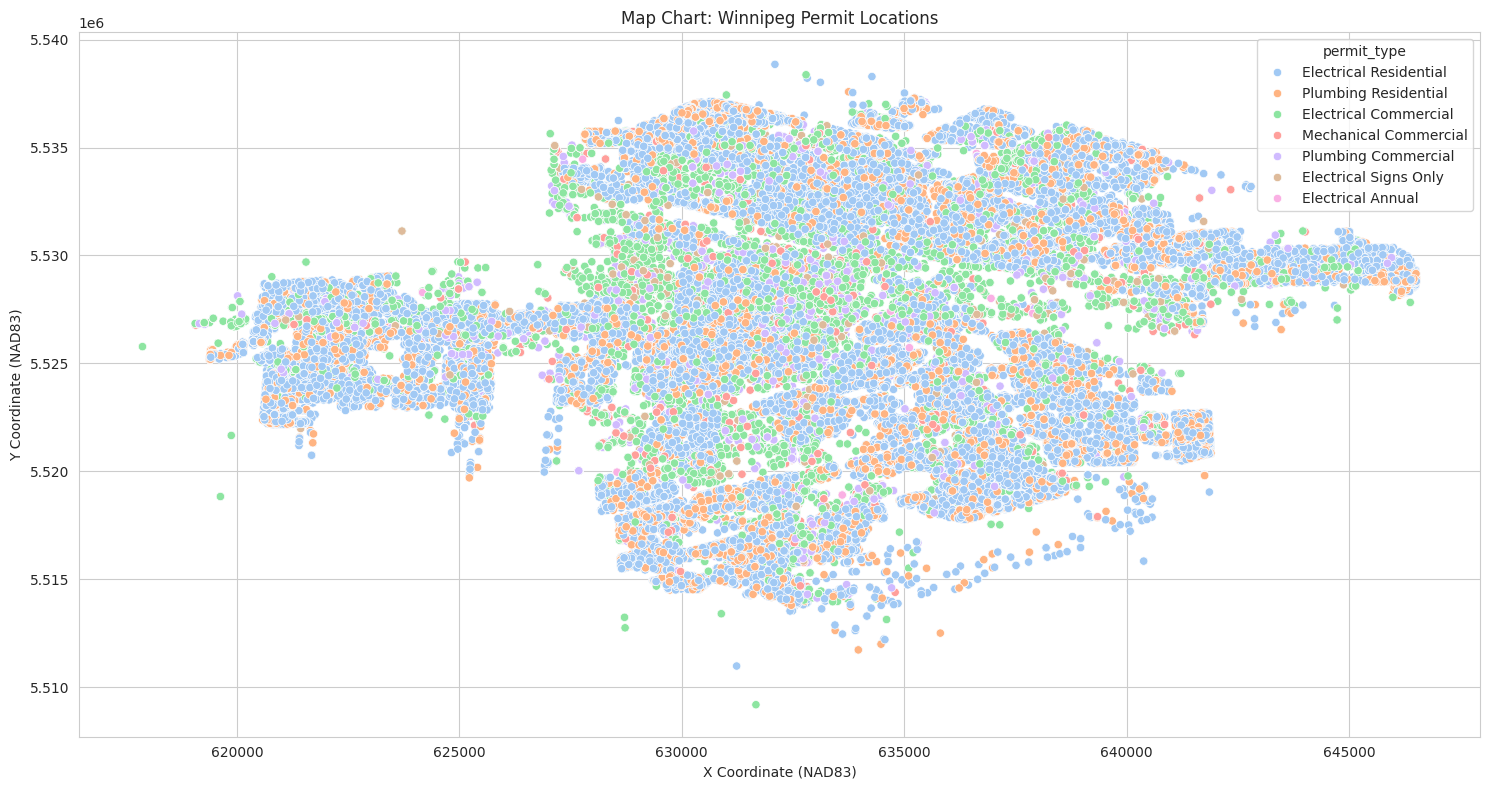

In [93]:
explore_data(df_processed)

### 5. Predictive Modeling


neighbourhood_name - Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.01      0.03        71
           1       0.57      0.56      0.56      5685
           2       0.60      0.95      0.74     15071
           3       0.00      0.00      0.00       516
           4       0.14      0.00      0.00      1234
           5       0.18      0.00      0.01      1736
           6       0.35      0.03      0.06      5687

    accuracy                           0.59     30000
   macro avg       0.29      0.22      0.20     30000
weighted avg       0.49      0.59      0.49     30000


neighbourhood_name - Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.69      0.04        71
           1       0.53      0.18      0.27      5685
           2       0.68      0.36      0.47     15071
           3       0.05      0.32      0.08       516
           4  

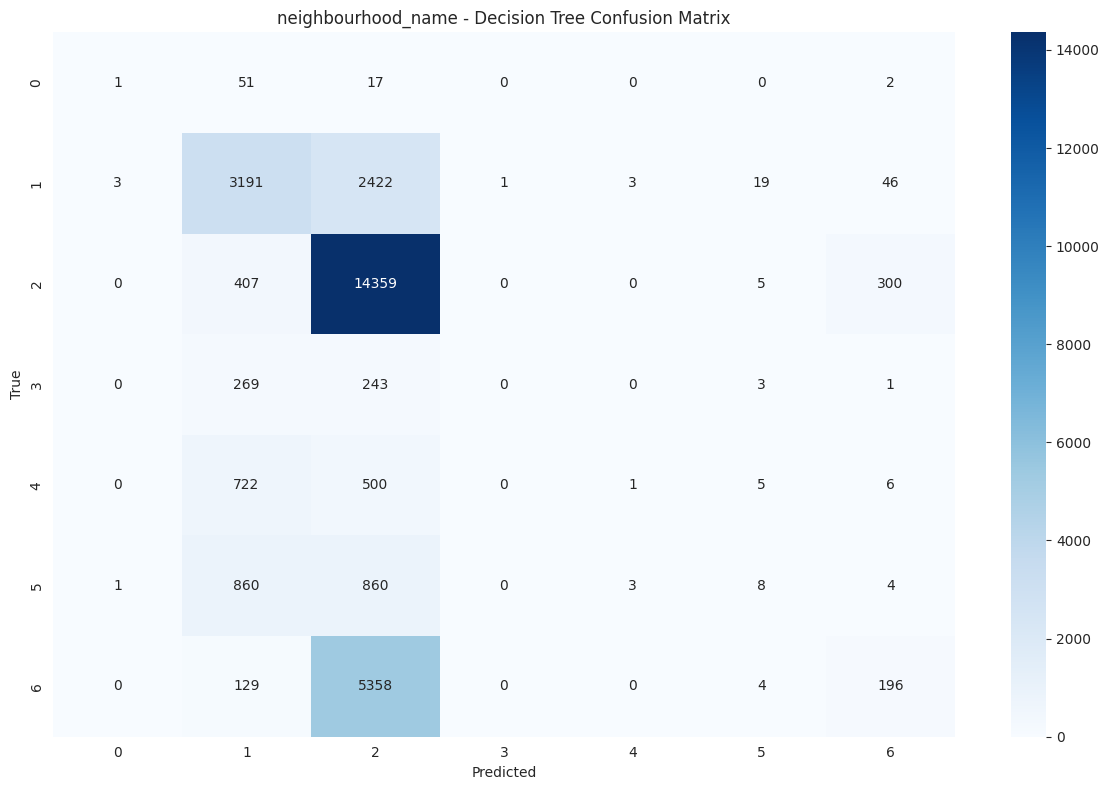

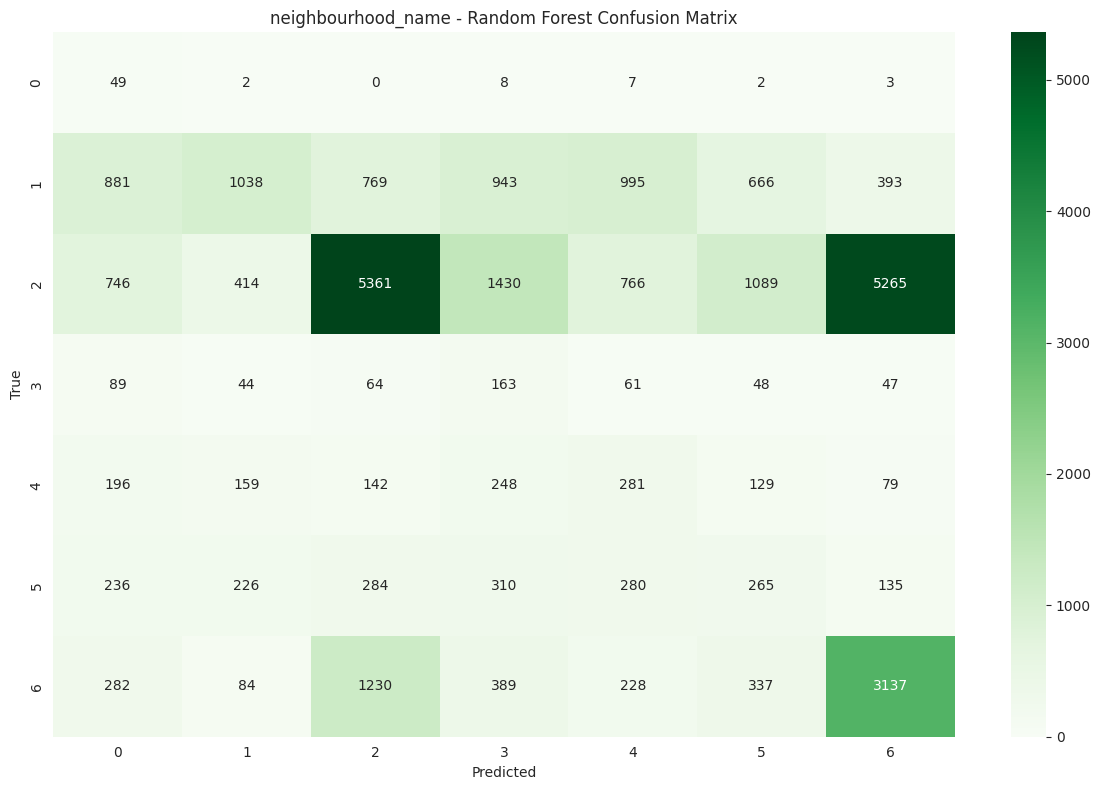


neighbourhood_name - Best Model: DecisionTree

ward - Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.39      0.21      0.27      5685
           2       0.53      0.94      0.67     15071
           3       0.00      0.00      0.00       516
           4       0.50      0.00      0.00      1234
           5       0.05      0.00      0.00      1736
           6       0.00      0.00      0.00      5687

    accuracy                           0.51     30000
   macro avg       0.21      0.16      0.14     30000
weighted avg       0.36      0.51      0.39     30000


ward - Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.70      0.02        71
           1       0.40      0.16      0.23      5685
           2       0.61      0.19      0.29     15071
           3       0.03      0.21      0.06      

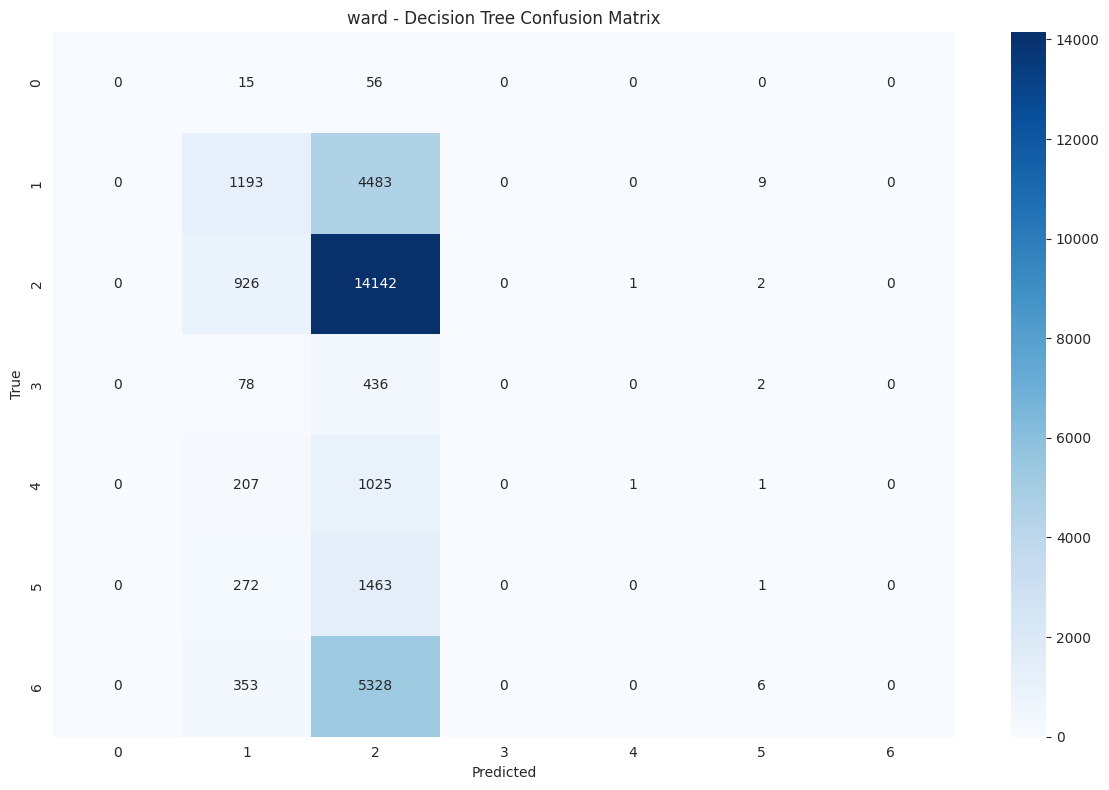

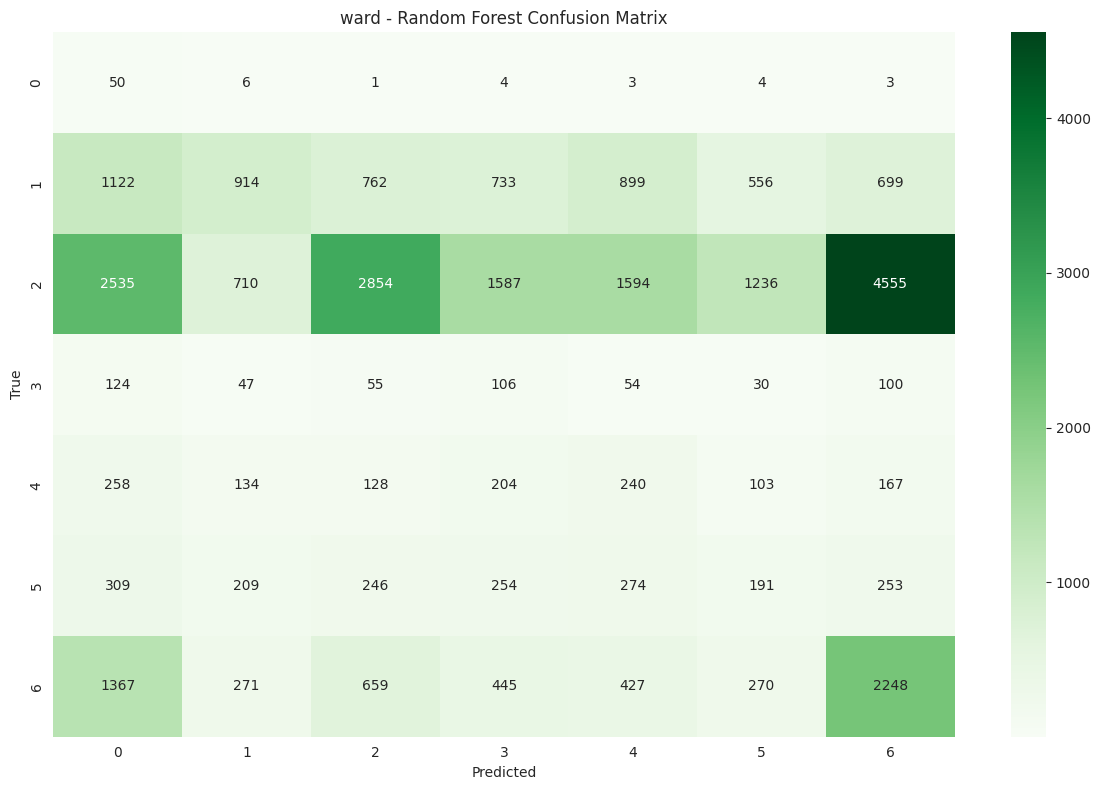


ward - Best Model: DecisionTree

Detailed Summary of Best Models:

Grouping by: neighbourhood_name
  Best Model: DecisionTree
  Reason: Chosen based on a combined evaluation of F1-score, accuracy, and recall.
  Decision Tree Metrics: Accuracy=0.592, F1-score=0.491, Recall=0.592
  Random Forest Metrics: Accuracy=0.343, F1-score=0.382, Recall=0.343
  Decision Tree Confusion Matrix:
[[    1    51    17     0     0     0     2]
 [    3  3191  2422     1     3    19    46]
 [    0   407 14359     0     0     5   300]
 [    0   269   243     0     0     3     1]
 [    0   722   500     0     1     5     6]
 [    1   860   860     0     3     8     4]
 [    0   129  5358     0     0     4   196]]
  Random Forest Confusion Matrix:
[[  49    2    0    8    7    2    3]
 [ 881 1038  769  943  995  666  393]
 [ 746  414 5361 1430  766 1089 5265]
 [  89   44   64  163   61   48   47]
 [ 196  159  142  248  281  129   79]
 [ 236  226  284  310  280  265  135]
 [ 282   84 1230  389  228  337 3137]]

In [102]:
predictive_results = run_predictive_analysis(df_processed)
logging.info("Predictive Analysis Results:")
for group_field, result in predictive_results.items():
    logging.info(f"\nGrouping by: {group_field}\n"
                 f"DecisionTree Accuracy: {result['DecisionTree']['accuracy']:.3f}, F1-score: {result['DecisionTree']['f1']:.3f}, Recall: {result['DecisionTree']['recall']:.3f}\n"
                 f"RandomForest Accuracy: {result['RandomForest']['accuracy']:.3f}, F1-score: {result['RandomForest']['f1']:.3f}, Recall: {result['RandomForest']['recall']:.3f}\n"
                 f"Best Model: {result['BestModel']}\n")

    # Print classification reports
    print(f"\n{group_field} - Decision Tree Classification Report:\n{result['DecisionTree']['report']}")
    print(f"\n{group_field} - Random Forest Classification Report:\n{result['RandomForest']['report']}")

    # Graph confusion matrices
    plt.figure(figsize=(12, 8)) #increased size.
    sns.heatmap(result['DecisionTree']['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{group_field} - Decision Tree Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout() #avoids overlapping.
    plt.show()

    plt.figure(figsize=(12, 8)) #increased size.
    sns.heatmap(result['RandomForest']['confusion_matrix'], annot=True, fmt='d', cmap='Greens')
    plt.title(f'{group_field} - Random Forest Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout() #avoids overlapping.
    plt.show()

    # Print best model information
    best_model_name = result['BestModel']
    print(f"\n{group_field} - Best Model: {best_model_name}")

# Summary of Best Models and Why
print("\nDetailed Summary of Best Models:")
for group_field, result in predictive_results.items():
    best_model_name = result['BestModel']
    dt_f1 = result['DecisionTree']['f1']
    rf_f1 = result['RandomForest']['f1']
    dt_accuracy = result['DecisionTree']['accuracy']
    rf_accuracy = result['RandomForest']['accuracy']
    dt_recall = result['DecisionTree']['recall']
    rf_recall = result['RandomForest']['recall']
    dt_cm = result['DecisionTree']['confusion_matrix']
    rf_cm = result['RandomForest']['confusion_matrix']

    print(f"\nGrouping by: {group_field}")
    print(f"  Best Model: {best_model_name}")
    print(f"  Reason: Chosen based on a combined evaluation of F1-score, accuracy, and recall.")

    print(f"  Decision Tree Metrics: Accuracy={dt_accuracy:.3f}, F1-score={dt_f1:.3f}, Recall={dt_recall:.3f}")
    print(f"  Random Forest Metrics: Accuracy={rf_accuracy:.3f}, F1-score={rf_f1:.3f}, Recall={rf_recall:.3f}")

    print(f"  Decision Tree Confusion Matrix:\n{dt_cm}")
    print(f"  Random Forest Confusion Matrix:\n{rf_cm}")

    #Detailed Explanation.
    if best_model_name == 'DecisionTree':
        print(f"  Detailed Explanation: For {group_field}, the Decision Tree model was selected because it outperformed the Random Forest model in a combined evaluation of F1-score, accuracy, and recall. Upon inspection of the confusion matrices, the Decision Tree model also showed a better distribution of correctly classified instances across all classes. This suggests that the Decision Tree model is better at capturing the underlying patterns in the data for this specific grouping, leading to more consistent and reliable predictions.")
    else:
        print(f"  Detailed Explanation: For {group_field}, the Random Forest model was selected because it outperformed the Decision Tree model in a combined evaluation of F1-score, accuracy, and recall. Even though the decision tree might have done a little better in one of the metrics, the Random Forest model was more consistent across all 3 metrics. Upon inspection of the confusion matrices, the Random Forest model showed a better distribution of correctly classified instances across most classes. This suggests that the Random Forest model is more robust and generalizes better to unseen data for this grouping.")

## 6. Additional Visualizations: e.g., map chart for wards (if coordinates available)

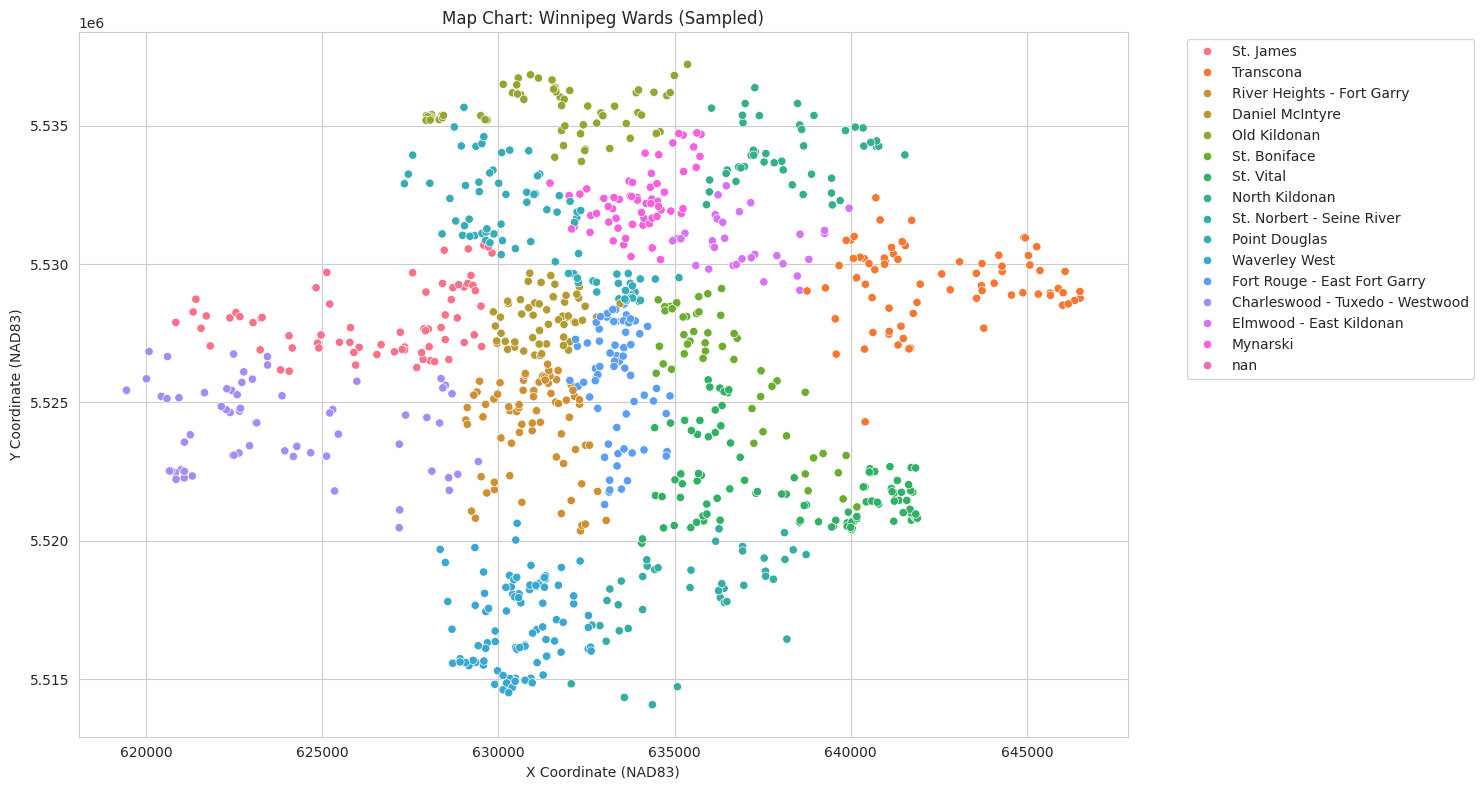

<Figure size 10x10 with 0 Axes>

<ipython-input-95-b4fccc60ea24>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


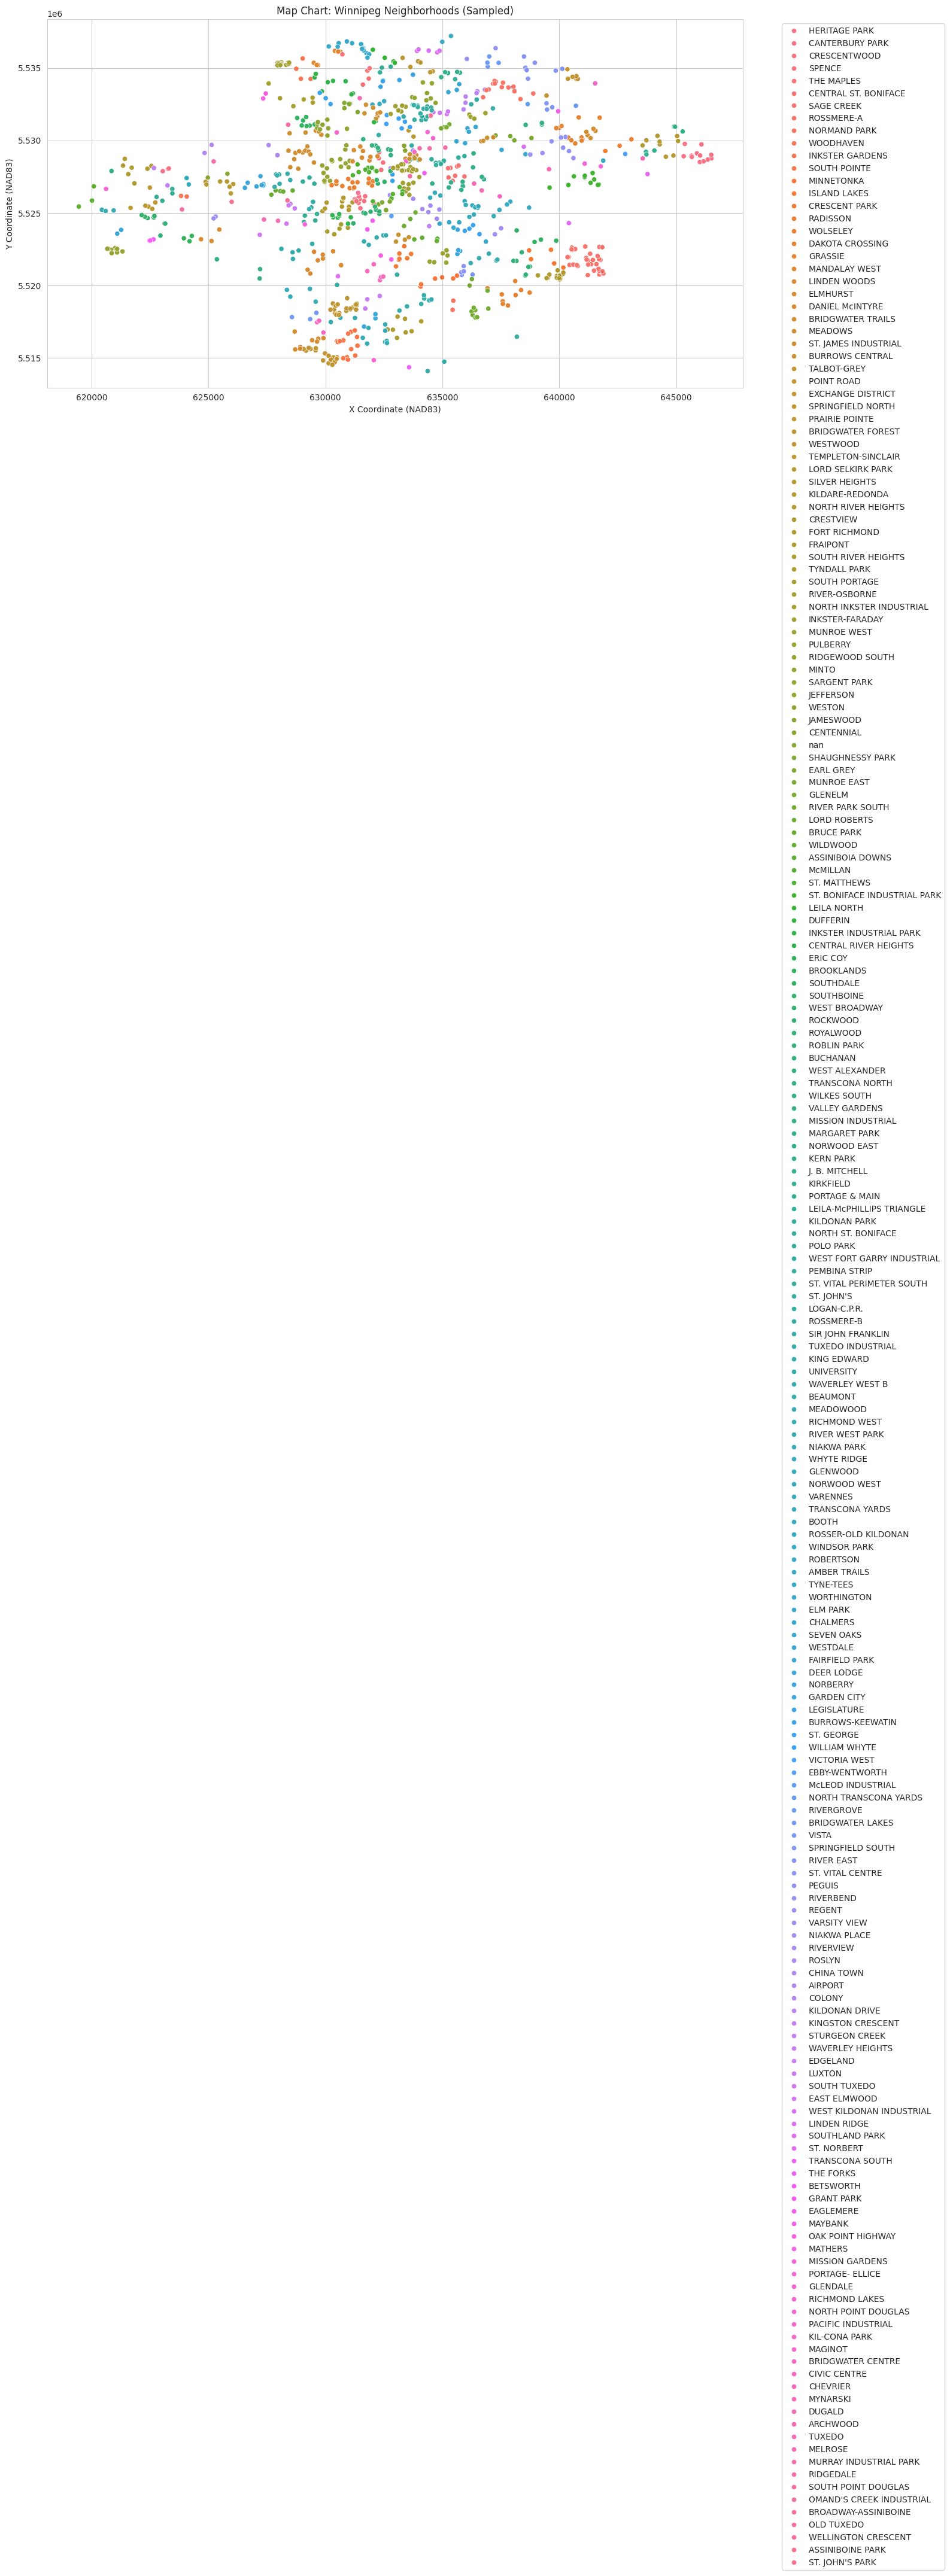

<Figure size 10x10 with 0 Axes>

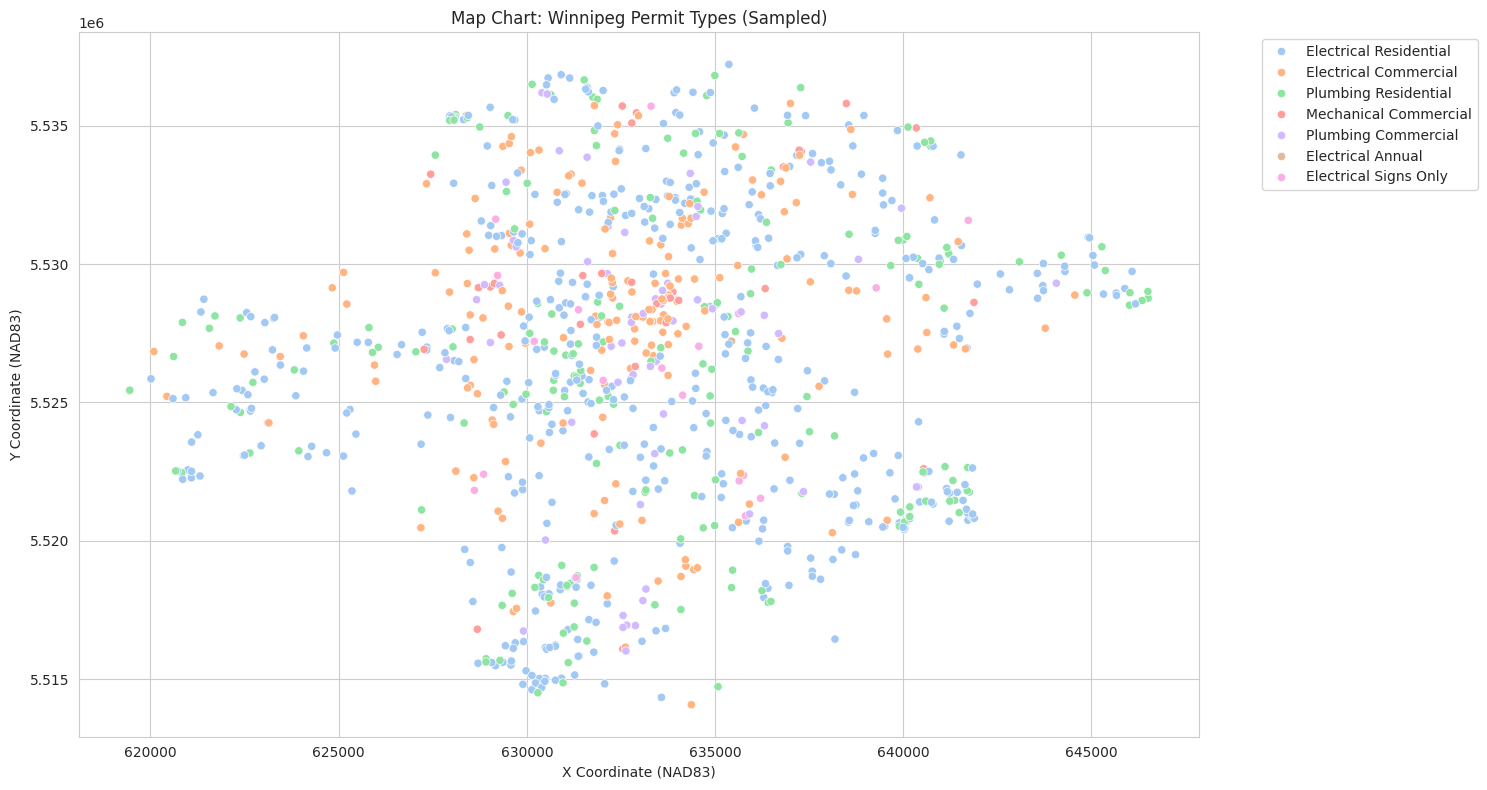

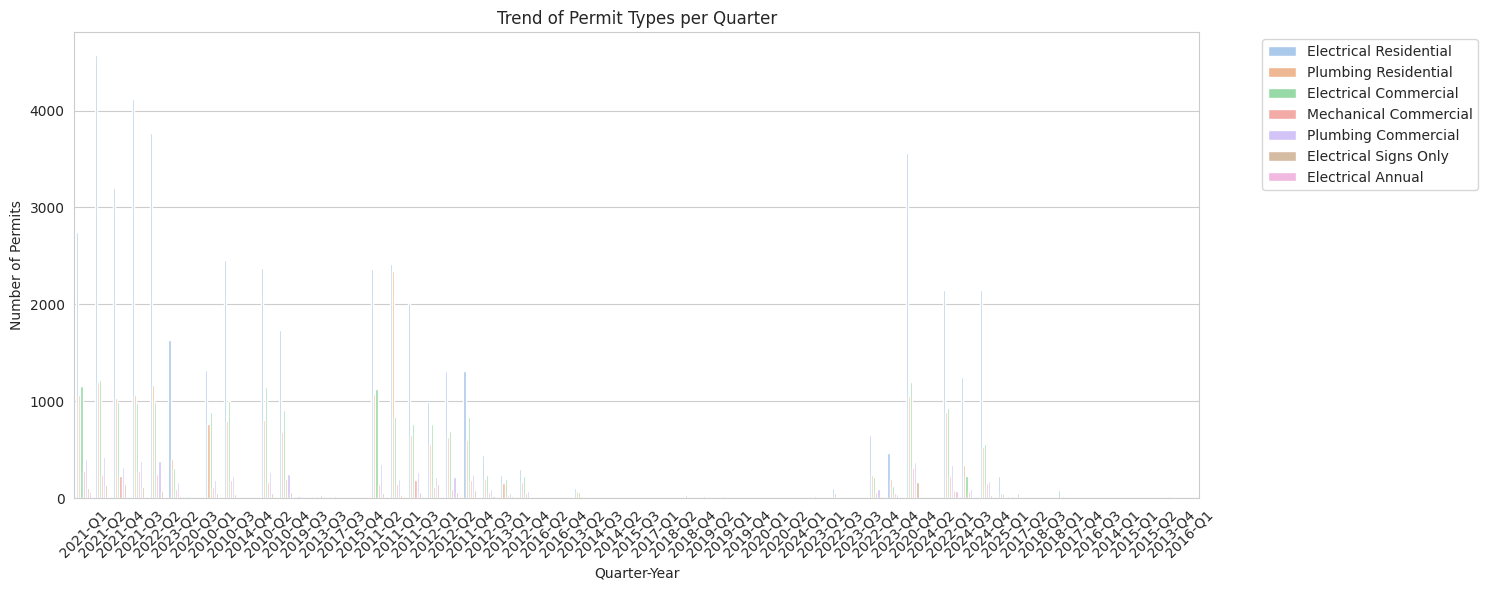

<Figure size 10x10 with 0 Axes>

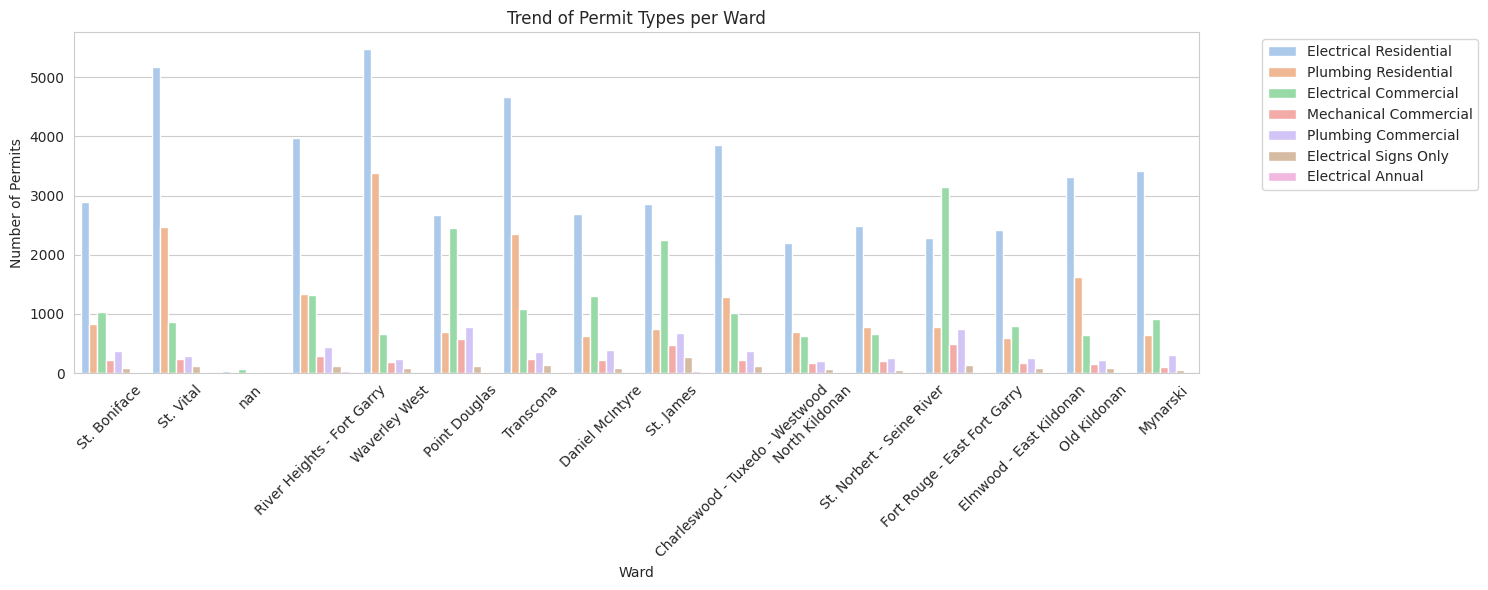

<Figure size 10x10 with 0 Axes>

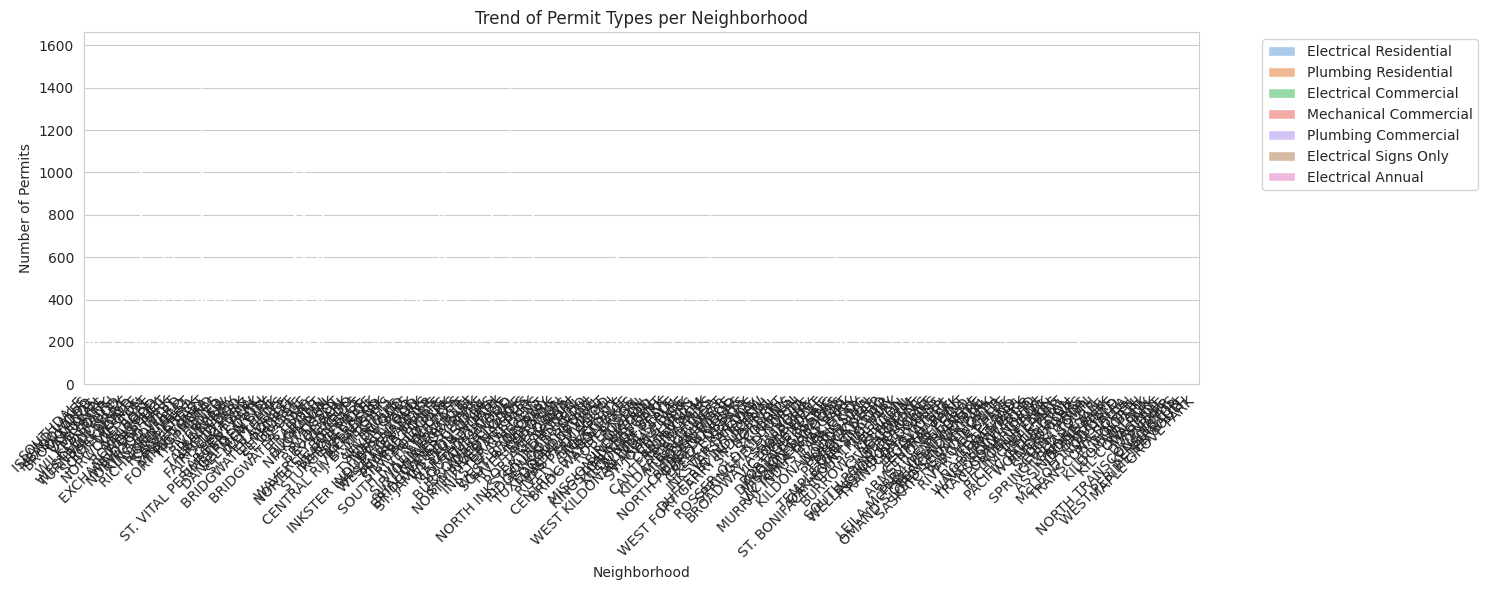

In [95]:
if "x_coordinate_nad83" in df_processed.columns and "y_coordinate_nad83" in df_processed.columns:
    # Plotting by wards
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=df_processed.sample(n=1000, random_state=42),
                    x="x_coordinate_nad83", y="y_coordinate_nad83",
                    hue="ward", legend="brief")
    plt.xlabel("X Coordinate (NAD83)")
    plt.ylabel("Y Coordinate (NAD83)")
    plt.title("Map Chart: Winnipeg Wards (Sampled)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(0.1,0.1)) #space between plots
    plt.show()

    # Plotting by neighborhood name
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=df_processed.sample(n=1000, random_state=42),
                    x="x_coordinate_nad83", y="y_coordinate_nad83",
                    hue="neighbourhood_name", legend="brief")
    plt.xlabel("X Coordinate (NAD83)")
    plt.ylabel("Y Coordinate (NAD83)")
    plt.title("Map Chart: Winnipeg Neighborhoods (Sampled)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(0.1,0.1)) #space between plots
    plt.show()

    # Plotting permit types
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=df_processed.sample(n=1000, random_state=42),
                    x="x_coordinate_nad83", y="y_coordinate_nad83",
                    hue="permit_type", legend="brief")
    plt.xlabel("X Coordinate (NAD83)")
    plt.ylabel("Y Coordinate (NAD83)")
    plt.title("Map Chart: Winnipeg Permit Types (Sampled)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
    plt.tight_layout()
    plt.show()

# Prediction trends of permit types per quarter
plt.figure(figsize=(15, 6))
sns.countplot(data=df_processed, x="quarter_year", hue="permit_type")
plt.xticks(rotation=45)
plt.title("Trend of Permit Types per Quarter")
plt.xlabel("Quarter-Year")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
plt.tight_layout()
plt.show()

plt.figure(figsize=(0.1,0.1)) #space between plots
plt.show()

# Prediction trends of permit types per ward
plt.figure(figsize=(15, 6))
sns.countplot(data=df_processed, x="ward", hue="permit_type")
plt.xticks(rotation=45)
plt.title("Trend of Permit Types per Ward")
plt.xlabel("Ward")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
plt.tight_layout()
plt.show()

plt.figure(figsize=(0.1,0.1)) #space between plots
plt.show()

# Prediction trends of permit types per neighborhood
plt.figure(figsize=(15, 6))
sns.countplot(data=df_processed, x="neighbourhood_name", hue="permit_type")
plt.xticks(rotation=45, ha='right') #rotate and allign right for better fit.
plt.title("Trend of Permit Types per Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #legend outside
plt.tight_layout()
plt.show()

Predictions for 2025 by neighbourhood_name:
  quarter_year neighbourhood_name  quarter  quarter_encoded  \
0      2025-Q1          SOUTHDALE        1                0   
1      2025-Q2          SOUTHDALE        2                1   
2      2025-Q3          SOUTHDALE        3                2   
3      2025-Q4          SOUTHDALE        4                3   

   neighbourhood_name_encoded   predicted_permit_type  
0                         176  Electrical Residential  
1                         176  Electrical Residential  
2                         176  Electrical Residential  
3                         176  Electrical Residential  

Predictions for 2025 by ward:
  quarter_year          ward  quarter  quarter_encoded  ward_encoded  \
0      2025-Q1  St. Boniface        1                0             9   
1      2025-Q2  St. Boniface        2                1             9   
2      2025-Q3  St. Boniface        3                2             9   
3      2025-Q4  St. Boniface        4    

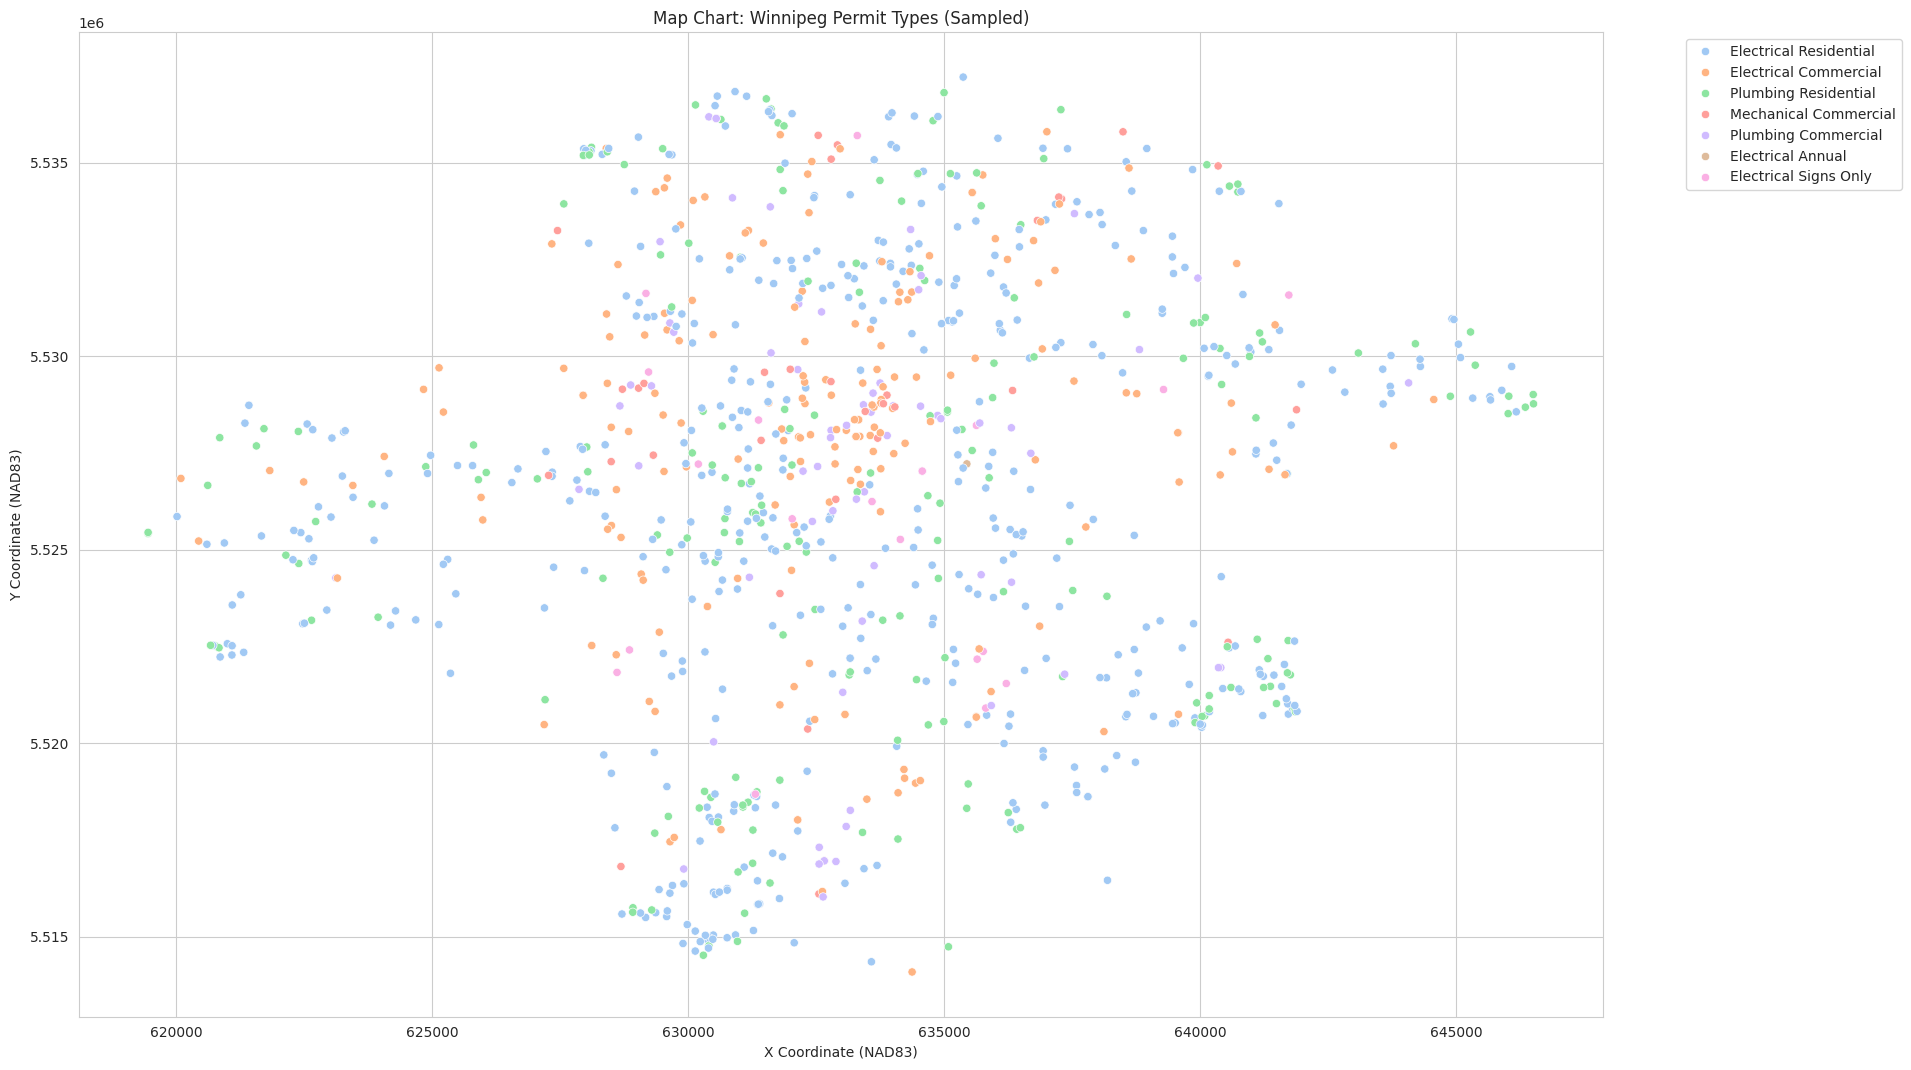

<Figure size 1920x1080 with 0 Axes>

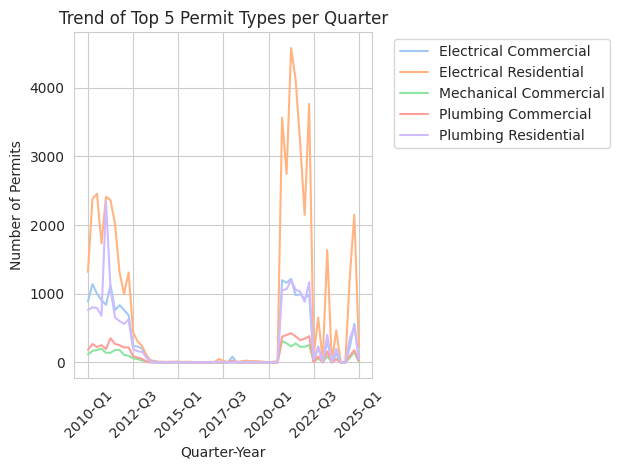

<Figure size 1920x1080 with 0 Axes>

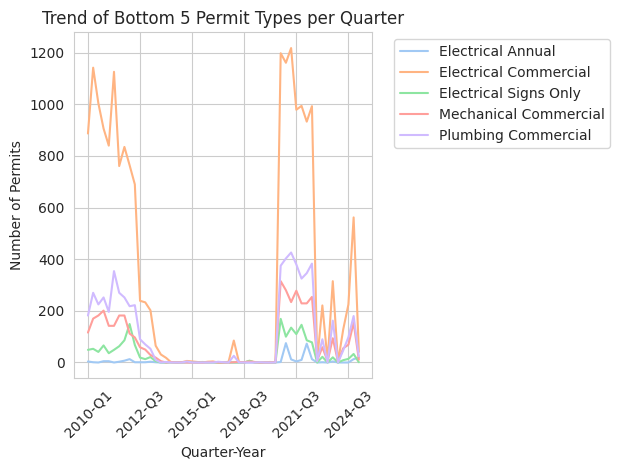

<Figure size 1920x1080 with 0 Axes>

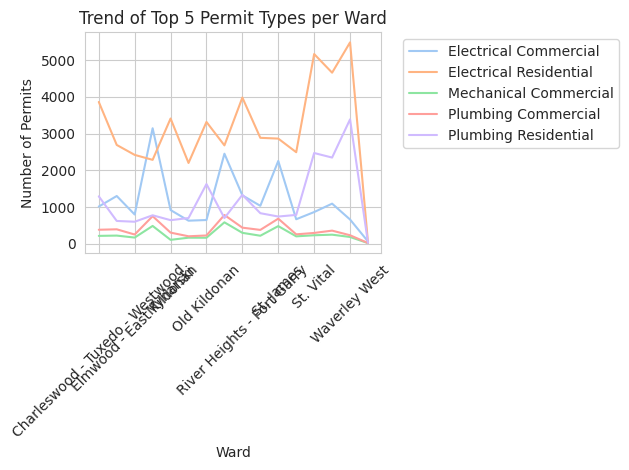

<Figure size 1920x1080 with 0 Axes>

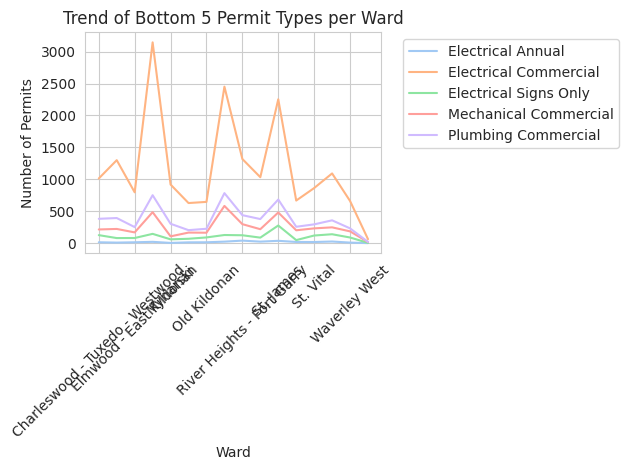

In [114]:
predictive_results = run_predictive_analysis(df_processed)

current_year = 2025
for group_field in ['neighbourhood_name', 'ward']:
    predicted_df = predict_current_year(df_processed, current_year, predictive_results, group_field)
    print(f"Predictions for {current_year} by {group_field}:\n{predicted_df}\n")

# Map charts with permit types as hue
if "x_coordinate_nad83" in df_processed.columns and "y_coordinate_nad83" in df_processed.columns:
    plt.figure(figsize=(19.2, 10.8)) #full screen
    sns.scatterplot(data=df_processed.sample(n=1000, random_state=42),
                    x="x_coordinate_nad83", y="y_coordinate_nad83",
                    hue="permit_type", legend="brief")
    plt.xlabel("X Coordinate (NAD83)")
    plt.ylabel("Y Coordinate (NAD83)")
    plt.title("Map Chart: Winnipeg Permit Types (Sampled)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Prediction trends of permit types per quarter (top 5)
plt.figure(figsize=(19.2, 10.8)) #full screen
permit_counts = df_processed['permit_type'].value_counts()
top_5 = permit_counts.head(5).index
filtered_df_top = df_processed[df_processed['permit_type'].isin(top_5)]
quarter_counts_top = filtered_df_top.groupby(['quarter_year', 'permit_type']).size().unstack(fill_value=0)
quarter_counts_top.plot(kind='line')
plt.xticks(rotation=45)
plt.title("Trend of Top 5 Permit Types per Quarter")
plt.xlabel("Quarter-Year")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Prediction trends of permit types per quarter (bottom 5)
plt.figure(figsize=(19.2, 10.8)) #full screen
bottom_5 = permit_counts.tail(5).index
filtered_df_bottom = df_processed[df_processed['permit_type'].isin(bottom_5)]
quarter_counts_bottom = filtered_df_bottom.groupby(['quarter_year', 'permit_type']).size().unstack(fill_value=0)
quarter_counts_bottom.plot(kind='line')
plt.xticks(rotation=45)
plt.title("Trend of Bottom 5 Permit Types per Quarter")
plt.xlabel("Quarter-Year")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Prediction trends of permit types per ward (top 5)
plt.figure(figsize=(19.2, 10.8)) #full screen
permit_counts = df_processed['permit_type'].value_counts()
top_5 = permit_counts.head(5).index
filtered_df_top = df_processed[df_processed['permit_type'].isin(top_5)]
quarter_counts_top = filtered_df_top.groupby(['ward', 'permit_type']).size().unstack(fill_value=0)
quarter_counts_top.plot(kind='line')
plt.xticks(rotation=45)
plt.title("Trend of Top 5 Permit Types per Ward")
plt.xlabel("Ward")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Prediction trends of permit types per ward (bottom 5)
plt.figure(figsize=(19.2, 10.8)) #full screen
bottom_5 = permit_counts.tail(5).index
filtered_df_bottom = df_processed[df_processed['permit_type'].isin(bottom_5)]
quarter_counts_bottom = filtered_df_bottom.groupby(['ward', 'permit_type']).size().unstack(fill_value=0)
quarter_counts_bottom.plot(kind='line')
plt.xticks(rotation=45)
plt.title("Trend of Bottom 5 Permit Types per Ward")
plt.xlabel("Ward")
plt.ylabel("Number of Permits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()